# Domain rank correlation

## Load data from Gaffer

In [1]:
import requests
import json
import sys
import gaffer
import threatgraph
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
# Number of 'top domains'
n = 5

In [3]:
g = threatgraph.Gaffer()
g.use_cert()

In [4]:
op = gaffer.OperationChain([
    gaffer.GetAllElements(entities=[
        gaffer.ViewGroup("device", exclude=["count", "time"])
    ], edges=None),
    gaffer.GetWalks(
        operations=[
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("hasip", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ]), 
            gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("dnsquery")
                ], entities=None, include="OUTGOING")
            ]), 
             gaffer.OperationChain(operations=[
                gaffer.GetElements(edges=[
                    gaffer.ViewGroup("indomain", exclude=["count", "time"])
                ], entities=None, include="OUTGOING")
            ])
        ],
        limit=10000000)
])

query = op.encode()
res = g.execute_chunked(op)

things = {}
timestamps = {}
counts = {}

all_things = set()
all_devices = set()

for v in res:

    try:
        ent = json.loads(v)

    except Exception:
        continue

    dev = list(ent["entities"][0].keys())[0]
    thing = list(ent["entities"][3].keys())[0]
    
    k = (dev, thing)

    if not k in counts:
        counts[k] = 0
        timestamps[k] = set()
        
    if not dev in things:
        things[dev] = set()

    ts = ent["edges"][1][0]["properties"]["time"]["uk.gov.gchq.gaffer.time.RBMBackedTimestampSet"]["timestamps"]
    cnt = ent["edges"][1][0]["properties"]["count"]

    counts[k] += cnt
    timestamps[k].update(ts)
    things[dev].add(thing)
    all_things.add(thing)
    all_devices.add(dev)

In [5]:
all_devices = list(all_devices)
all_things = list(all_things)

## Construct domain to device matrix

In [6]:
def get_counts(thing, dev):
    if thing in things[dev]: return counts[(dev, thing)]
    return 0

datas = [ [ get_counts(thing, dev) for dev in all_devices ] for thing in all_things]
df = pd.DataFrame(datas, index=all_things, columns=all_devices)

# Add a score column
df["score"] = df.sum(axis=1)
df

,daniel-chromebook,boundless-mac,MalcomWare-PC,castle3b7c9f,dramatic-mac,languid-mac,terrestrial-mac,misskitty-mac,serotinal-mac,calcannea-mac,...,ludicrous-mac,steamverne-mac,turing-chromebook,traverses-mac,tirasse-mac,mark-mac,essential-chrome,LAPTOP-1I501C4U,rarb-mac,score
asana.com,0,0,0,0,0,0,0,4,0,0,...,0,0,0,0,0,0,0,0,0,4
sims-online.com,0,0,0,0,5,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
gumroad.com,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
fvddtda.openvpn,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
Apple-TV-2.local,0,1,0,0,0,0,0,0,0,0,...,0,2,0,0,0,0,0,0,0,3
samplicio.us,0,0,0,0,0,0,0,0,0,0,...,0,16,0,0,0,0,0,0,0,16
joinhoney.com,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
expandurl.net,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
salesforce.com,0,2,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,3
spotify.com,0,0,0,0,389,0,0,0,0,0,...,0,0,0,0,0,2,0,0,0,958


## Get list of highest accessed domains by all devices

In [7]:
top_domains = df.sort_values(by="score", ascending=False).index.values[:n]
top_domains

array(['google.com', 'gstatic.com', 'trustnetworks.com', 'googleapis.com',
       'apple.com'], dtype=object)

## Spearman's Rho

In [8]:
# Calculate Rho on 2 lists
def spearman(a, b):
    
    n = len(a)
    bmap = {b[i]: i for i in range(0, len(b)) }

    tot = 0
    for i in range(0, len(a)):
        if a[i] in bmap:
            val = bmap[a[i]] - i
        else:
            val = len(b)
        val = val * val
        
        tot += val
    return 1.0 - ( (6 * tot) / ( n * (n * n - 1) ) )

In [9]:
spearman(["b", "a", "x"], ["a", "c", "x"])

-1.5

In [10]:
spearman(["a", "c", "x"], ["b", "a", "x"])

-1.5

## Get favourite domains by device

In [11]:
fav_domains = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]
fav_domains

[['daniel-chromebook',
  array(['google.com', 'googleapis.com', 'slack-msgs.com', 'gstatic.com',
         'googleusercontent.com'], dtype=object)],
 ['boundless-mac',
  array(['google.com', 'in-addr.arpa', 'apple.com', 'clubhouse.io',
         'gstatic.com'], dtype=object)],
 ['MalcomWare-PC',
  array(['ddns.net', 'trustnetworks.com', 'microsoft.com', 'google.com',
         'msftncsi.com'], dtype=object)],
 ['castle3b7c9f',
  array(['netgear.com', 'asana.com', 'seatguru.com', 'johnlewisfinance.com',
         'bbthat.com'], dtype=object)],
 ['dramatic-mac',
  array(['google.com', 'apple.com', 'rbxcdn.com', 'in-addr.arpa',
         'amazonaws.com'], dtype=object)],
 ['languid-mac',
  array(['google.com', 'in-addr.arpa', 'apple.com', 'gstatic.com',
         'doubleclick.net'], dtype=object)],
 ['terrestrial-mac',
  array(['google.com', 'gstatic.com', 'apple.com', 'googleapis.com',
         'in-addr.arpa'], dtype=object)],
 ['misskitty-mac',
  array(['google.com', 'akadns.net', 'googleapis

In [12]:
df2 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")
df2

,domains
device,
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g..."
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous..."
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g..."
castle3b7c9f,"[netgear.com, asana.com, seatguru.com, johnlew..."
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar..."
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic...."
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi..."
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat..."
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst..."


## Compute Spearman co-efficient
against most common domains

In [13]:
df2["coefficient"] = df2["domains"].apply(lambda x: spearman(x, top_domains)).round(2)

In [14]:
df2.sort_values(by="coefficient", ascending=False)[["domains", "coefficient"]]

,domains,coefficient
device,,
simon-macpro,"[google.com, gstatic.com, akadns.net, apple.co...",-0.35
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-0.45
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-0.50
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",-0.65
essential-cb,"[google.com, clubhouse.io, gstatic.com, google...",-1.55
tirasse-mac,"[google.com, in-addr.arpa, gstatic.com, clubho...",-1.55
steamverne-mac,"[google.com, doubleclick.net, gstatic.com, goo...",-1.55
elysium-mac,"[google.com, gstatic.com, googleapis.com, goog...",-1.55
rarb-mac,"[google.com, in-addr.arpa, apple.com, googleap...",-1.70


## Device to device co-efficient

In [15]:
everyone = [ [v, df.sort_values(by=v, ascending=False)[[v, "score"]][:n][v].index.values] for v in all_devices ]

In [16]:
df3 = pd.DataFrame(fav_domains, columns=["device", "domains"]).set_index("device")

In [17]:
for dev, domains in everyone:
    df3[dev] = df3["domains"].apply(lambda x: spearman(domains, x)).round(2)

In [18]:
df3

,domains,daniel-chromebook,boundless-mac,MalcomWare-PC,castle3b7c9f,dramatic-mac,languid-mac,terrestrial-mac,misskitty-mac,serotinal-mac,...,abroad-android,ludicrous-mac,steamverne-mac,turing-chromebook,traverses-mac,tirasse-mac,mark-mac,essential-chrome,LAPTOP-1I501C4U,rarb-mac
device,,,,,,,,,,,,,,,,,,,,,
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g...",1.00,-2.80,-4.45,-5.25,-4.00,-2.75,-1.90,-1.55,-1.50,...,-1.55,-3.25,-1.75,-0.30,-4.00,-2.80,-4.20,-1.60,-4.80,-2.95
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",-2.80,1.00,-4.45,-5.25,-1.75,-0.30,-1.15,-1.75,-0.55,...,-2.75,-1.60,-1.75,-2.95,-1.60,0.60,-4.20,-1.70,-4.80,-1.50
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",-4.45,-4.45,1.00,-5.25,-4.45,-4.45,-4.45,-4.45,-4.45,...,-4.45,-4.20,-4.45,-4.45,-4.45,-4.45,-4.05,-4.45,-1.75,-4.45
castle3b7c9f,"[netgear.com, asana.com, seatguru.com, johnlew...",-5.25,-5.25,-5.25,1.00,-5.25,-5.25,-5.25,-5.25,-5.25,...,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25,-5.25
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",-4.00,-1.75,-4.45,-5.25,1.00,-1.75,-1.60,-3.20,-2.00,...,-4.00,-2.05,-4.00,-4.00,-1.55,-2.15,-4.20,-4.00,-4.80,-1.75
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",-2.75,-0.30,-4.45,-5.25,-1.75,1.00,-0.90,-1.70,-0.50,...,-2.80,-1.60,-2.00,-2.80,-1.60,-0.50,-4.20,-2.80,-4.80,-1.50
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",-1.90,-1.15,-4.45,-5.25,-1.60,-0.90,1.00,-0.70,0.20,...,-2.15,-1.15,-1.55,-1.75,-1.75,-0.95,-4.20,-2.00,-4.80,-0.70
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",-1.55,-1.75,-4.45,-5.25,-3.20,-1.70,-0.70,1.00,-0.30,...,-1.60,-1.95,-1.60,-1.60,-2.15,-1.55,-4.20,-1.55,-4.80,-1.75
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",-1.50,-0.55,-4.45,-5.25,-2.00,-0.50,0.20,-0.30,1.00,...,-1.55,-1.15,-1.75,-1.55,-1.95,-0.35,-4.20,-1.60,-4.80,-0.70


In [19]:
## Calculate log10(coefficient)
my_fn = lambda x: np.log10(x + 10)
df4 = df3.copy()
df4[all_devices] = df4[all_devices].apply(lambda x: [my_fn(v) for v in x]).round(2)

In [20]:
df4

,domains,daniel-chromebook,boundless-mac,MalcomWare-PC,castle3b7c9f,dramatic-mac,languid-mac,terrestrial-mac,misskitty-mac,serotinal-mac,...,abroad-android,ludicrous-mac,steamverne-mac,turing-chromebook,traverses-mac,tirasse-mac,mark-mac,essential-chrome,LAPTOP-1I501C4U,rarb-mac
device,,,,,,,,,,,,,,,,,,,,,
daniel-chromebook,"[google.com, googleapis.com, slack-msgs.com, g...",1.04,0.86,0.74,0.68,0.78,0.86,0.91,0.93,0.93,...,0.93,0.83,0.92,0.99,0.78,0.86,0.76,0.92,0.72,0.85
boundless-mac,"[google.com, in-addr.arpa, apple.com, clubhous...",0.86,1.04,0.74,0.68,0.92,0.99,0.95,0.92,0.98,...,0.86,0.92,0.92,0.85,0.92,1.03,0.76,0.92,0.72,0.93
MalcomWare-PC,"[ddns.net, trustnetworks.com, microsoft.com, g...",0.74,0.74,1.04,0.68,0.74,0.74,0.74,0.74,0.74,...,0.74,0.76,0.74,0.74,0.74,0.74,0.77,0.74,0.92,0.74
castle3b7c9f,"[netgear.com, asana.com, seatguru.com, johnlew...",0.68,0.68,0.68,1.04,0.68,0.68,0.68,0.68,0.68,...,0.68,0.68,0.68,0.68,0.68,0.68,0.68,0.68,0.68,0.68
dramatic-mac,"[google.com, apple.com, rbxcdn.com, in-addr.ar...",0.78,0.92,0.74,0.68,1.04,0.92,0.92,0.83,0.90,...,0.78,0.90,0.78,0.78,0.93,0.89,0.76,0.78,0.72,0.92
languid-mac,"[google.com, in-addr.arpa, apple.com, gstatic....",0.86,0.99,0.74,0.68,0.92,1.04,0.96,0.92,0.98,...,0.86,0.92,0.90,0.86,0.92,0.98,0.76,0.86,0.72,0.93
terrestrial-mac,"[google.com, gstatic.com, apple.com, googleapi...",0.91,0.95,0.74,0.68,0.92,0.96,1.04,0.97,1.01,...,0.89,0.95,0.93,0.92,0.92,0.96,0.76,0.90,0.72,0.97
misskitty-mac,"[google.com, akadns.net, googleapis.com, gstat...",0.93,0.92,0.74,0.68,0.83,0.92,0.97,1.04,0.99,...,0.92,0.91,0.92,0.92,0.89,0.93,0.76,0.93,0.72,0.92
serotinal-mac,"[google.com, googleapis.com, in-addr.arpa, gst...",0.93,0.98,0.74,0.68,0.90,0.98,1.01,0.99,1.04,...,0.93,0.95,0.92,0.93,0.91,0.98,0.76,0.92,0.72,0.97


## Plot it, heatmap

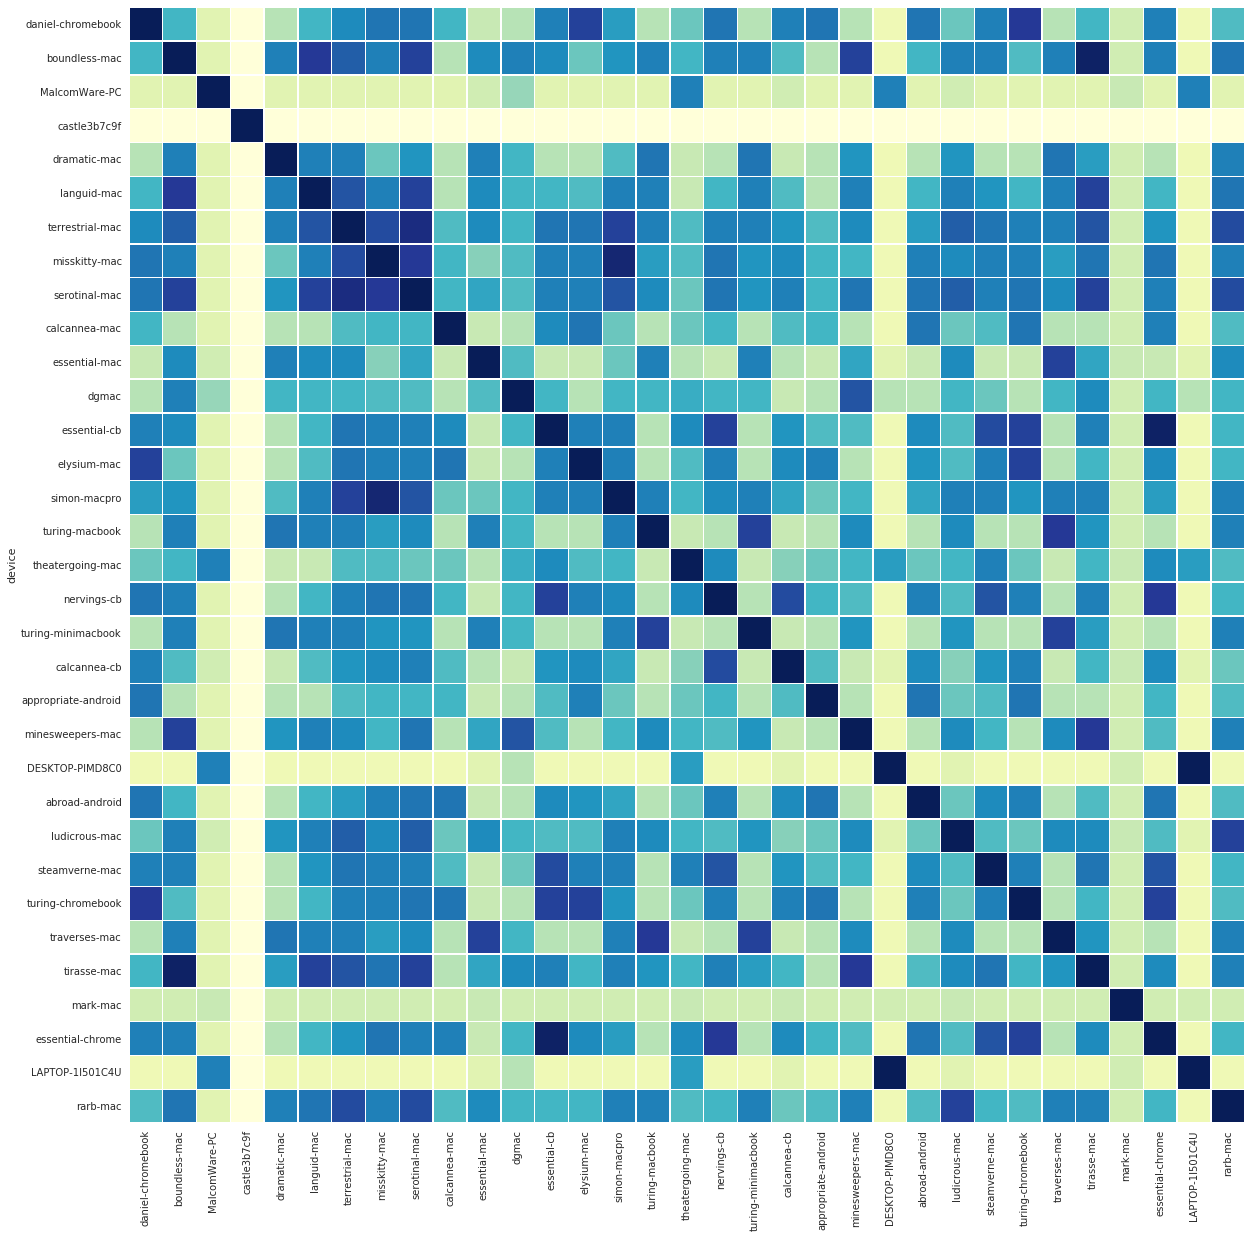

In [21]:
sns.set(style="white")
plt.figure(figsize=(20, 30))
sns.heatmap(df4[all_devices][all_devices], square=True, linewidths=0.5, cbar=False, cmap="YlGnBu")
plt.show()